# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> **2.1 Unsupervised GCN** ---> 3.1 Supervised MLP

### 1.1 Adjacency Matrix Generation ---> **2.2 Unsupervised GNODE** ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [96]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

#### Dataset:

[A short description here]

name: X_test
shape: (640, 50, 1830)
-----------------------
name: X_train
shape: (640, 50, 1804)
-----------------------
name: clip_sizes_test
shape: (2, 70)
-----------------------
name: clip_sizes_train
shape: (2, 70)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1830)
-----------------------
name: sel_win_nums_train
shape: (1, 1804)
-----------------------
name: soz_ch_ids
shape: (22, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1830)
-----------------------
name: y_train
shape: (1, 1804)
-----------------------
print sample EGG signal from one node:


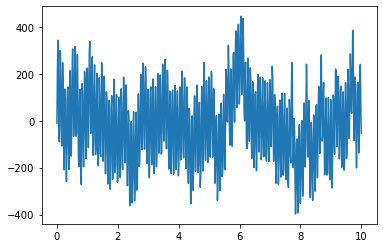

In [97]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_264.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [69]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

X_train: (640, 50, 1817)
X_test: (640, 50, 1817)
y_train: (1, 1817) Positive labes: 193.0
y_test: (1, 1817) Positive labes: 200.0


In [98]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [99]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


##### 1.1.2 Visualize the mean covariance matrix across all training samples

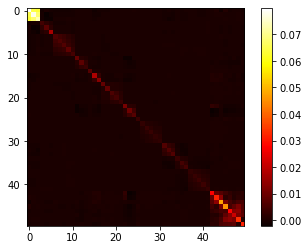

In [100]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

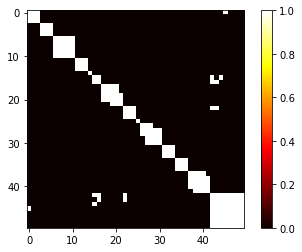

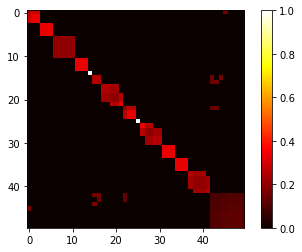

In [104]:
n = 0.7*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [105]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 257, 'M': 1804, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [106]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/15 [00:00<?, ?it/s]

device set to cpu


  7%|▋         | 1/15 [00:00<00:02,  4.92it/s]

 20%|██        | 3/15 [00:00<00:02,  4.82it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.79it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.70it/s]

 40%|████      | 6/15 [00:01<00:01,  4.60it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.70it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.76it/s]

Epoch: 1   Batch: 8 of size 128   Train loss: 881.0748291015625   Valid loss: 881.7643432617188

 60%|██████    | 9/15 [00:01<00:01,  4.81it/s]

Epoch: 1   Batch: ize 128   Train loss: 881.6987915039062   Valid loss: 881.7474365234375

 73%|███████▎  | 11/15 [00:02<00:00,  4.93it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.87it/s]

Epoch: 1   Batch: 12 of size 128   Train loss: 880.7479248046875   Valid loss: 879.3507690429688

 87%|████████▋ | 13/15 [00:02<00:00,  4.88it/s]

Epoch:atch: 13 of size 128   Train loss: 879.19189453125   Valid loss: 877.0982055664062

100%|██████████| 15/15 [00:02<00:00,  5.08it/s]

Epoch: 1   Batch: 15 of size 128   Train loss: 876.2733764648438   Valid loss: 873.3136596679688


In [107]:
#optional: saving the model
GCNutil.save_ckp(GCNcheckpoint, "models/GCNtest1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [108]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


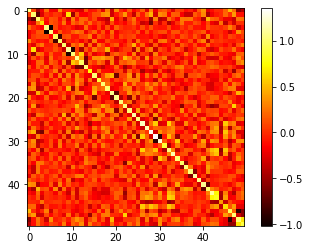

sample 1   label, 0.0


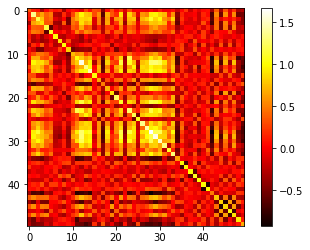

sample 2   label, 0.0


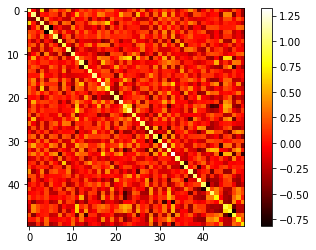

sample 3   label, 0.0


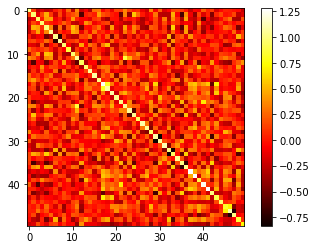

sample 4   label, 0.0


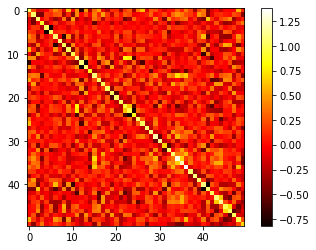

sample 5   label, 0.0


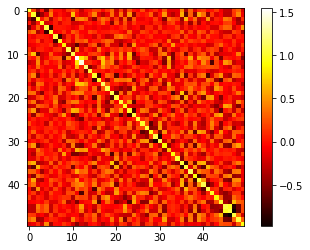

sample 6   label, 0.0


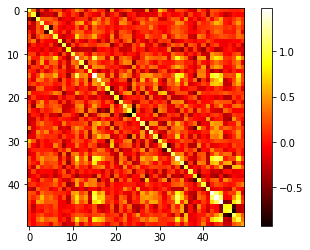

sample 7   label, 0.0


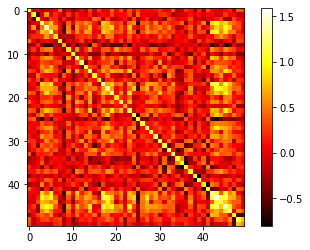

sample 8   label, 0.0


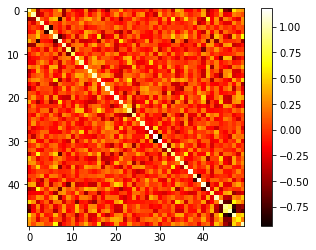

sample 9   label, 0.0


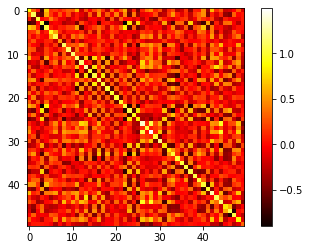

In [109]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Neural Ordinary Differential Equations (GNODE)

[short description here]

##### 2.2.1 Declare Parameters for GNODE

In [110]:
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEcheckpoint = {'parameters': GDEparameters}

##### 2.2.2 Train GNODE

In [111]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, X_train, X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/15 [00:00<?, ?it/s]

device set to cpu


  7%|▋         | 1/15 [00:00<00:10,  1.35it/s]

 13%|█▎        | 2/15 [00:01<00:09,  1.35it/s]

 20%|██        | 3/15 [00:02<00:09,  1.33it/s]

 27%|██▋       | 4/15 [00:03<00:08,  1.33it/s]

 33%|███▎      | 5/15 [00:03<00:07,  1.34it/s]

 40%|████      | 6/15 [00:04<00:06,  1.33it/s]

 47%|████▋     | 7/15 [00:05<00:06,  1.33it/s]

 53%|█████▎    | 8/15 [00:06<00:05,  1.33it/s]

 60%|██████    | 9/15 [00:06<00:04,  1.33it/s]

 67%|██████▋   | 10/15 [00:07<00:03,  1.33it/s]

 73%|███████▎  | 11/15 [00:08<00:03,  1.32it/s]

 80%|████████  | 12/15 [00:09<00:02,  1.34it/s]

 87%|████████▋ | 13/15 [00:09<00:01,  1.33it/s]

100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

Epoch: 1   Batch: 15 of size 128   Train loss: 874.5026245117188   Valid loss: 876.5311279296875


In [112]:
#optional: saving the model
GDEutil.save_ckp(GDEcheckpoint, "models/GDEtest1.pt")

model saved


##### 2.2.3 Visualize some simularity matrices generated by GNODE (a visual evaluation and sanity check)

In [113]:
GDEmodel.eval()
test_pred = GDEmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


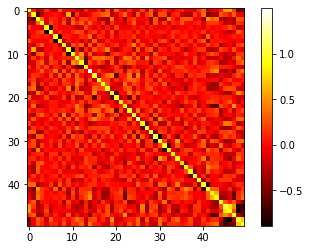

sample 1   label, 0.0


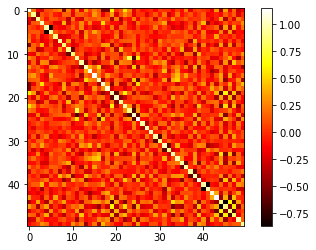

sample 2   label, 0.0


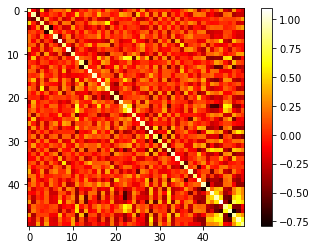

sample 3   label, 0.0


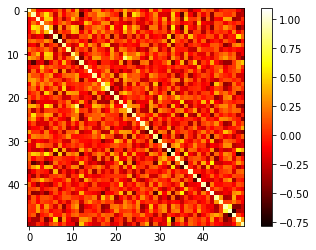

sample 4   label, 0.0


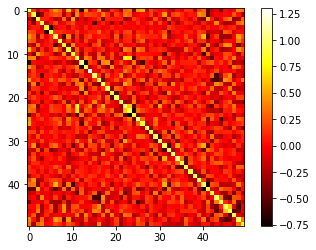

sample 5   label, 0.0


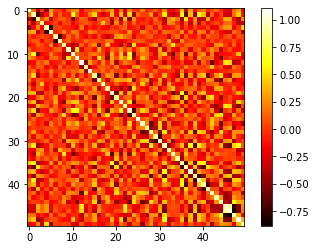

sample 6   label, 0.0


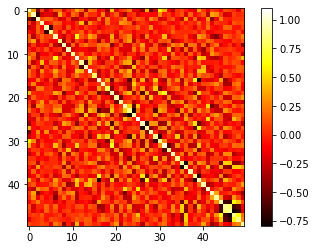

sample 7   label, 0.0


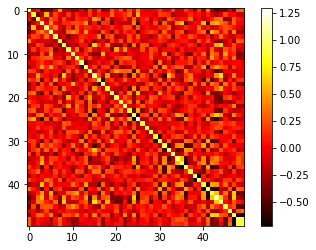

sample 8   label, 0.0


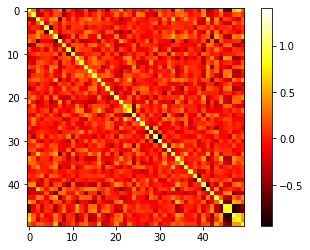

sample 9   label, 0.0


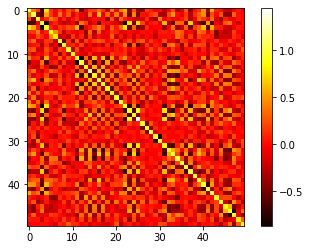

In [114]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 3.1 Supervised Multi-Layer Perceptron (MLP)

[short description here]

##### 3.1.1 Get simularity matrix from GCN and GNODE models

In [115]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

In [116]:
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [117]:
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

##### 3.1.2 Visualize the averaged ictal and non-ictal states for the two models

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


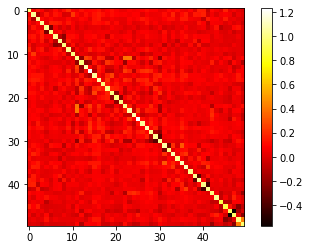

Average Non-Ictal


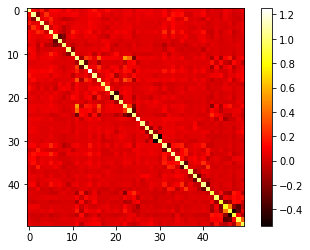

In [118]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


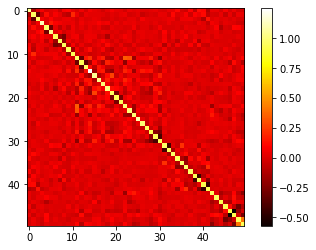

Average Non-Ictal


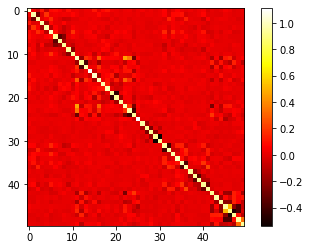

In [119]:
print("Average Ictal and Non-Ictal Simularity Matrix for GDE")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

##### 3.1.3 MLP for GCN  

###### Training

In [120]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[-1, -1],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_ = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=1275, out_features=1275, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1275, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1275]       1,626,900
              ReLU-2                 [-1, 1275]               0
            Linear-3                    [-1, 1]           1,276
           Sigmoid-4                    [-1, 1]               0
Total params: 1,628,176
Trainable params: 1,628,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 6.21
Estimated Total Size (MB): 6.24
----------------------------------------------------------------
Epoch: 1   Train loss: 0.3216   Train accuracy: 0.023   Val loss: 0.3516   Val accuracy: 0.372    w

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Epoch: 3   Train loss: 0.1392   Train accuracy: 0.739   Val loss: 0.3122   Val accuracy: 0.5    weighted Val loss: 0.3513
0.5 ----------saved-----------
Epoch: 4   Train loss: 0.099   Train accuracy: 0.86   Val loss: 0.359   Val accuracy: 0.495    weighted Val loss: 0.3514
Epoch: 5   Train loss: 0.0753   Train accuracy: 0.888   Val loss: 0.3715   Val accuracy: 0.488    weighted Val loss: 0.3515
Epoch: 6   Train loss: 0.0611   Train accuracy: 0.902   Val loss: 0.3933   Val accuracy: 0.491    weighted Val loss: 0.3517
Epoch: 7   Train loss: 0.0514   Train accuracy: 0.889   Val loss: 0.4272   Val accuracy: 0.51    weighted Val loss: 0.352
0.51 ----------saved-----------
Epoch: 8   Train loss: 0.0499   Train accuracy: 0.943   Val loss: 0.4238   Val accuracy: 0.512    weighted Val loss: 0.3524
0.512 ----------saved-----------
Epoch: 9   Train loss: 0.0437   Train accuracy: 0.867   Val loss: 0.4135   Val accuracy: 0.515    weighted Val loss: 0.3527
0.515 ----------saved-----------
Epoch: 10 

###### Result

In [121]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, threshold = t)

threshold: 0.05  validation loss: 0.4538 F1 accuracy 0.531 Precision accuracy 0.638 Recall accuracy 0.455 AUC accuracy: 0.711
threshold: 0.1  validation loss: 0.4538 F1 accuracy 0.552 Precision accuracy 0.8 Recall accuracy 0.421 AUC accuracy: 0.704
threshold: 0.15  validation loss: 0.4538 F1 accuracy 0.525 Precision accuracy 0.859 Recall accuracy 0.378 AUC accuracy: 0.685
threshold: 0.2  validation loss: 0.4538 F1 accuracy 0.508 Precision accuracy 0.872 Recall accuracy 0.359 AUC accuracy: 0.676
threshold: 0.25  validation loss: 0.4538 F1 accuracy 0.477 Precision accuracy 0.895 Recall accuracy 0.325 AUC accuracy: 0.66
threshold: 0.3  validation loss: 0.4538 F1 accuracy 0.457 Precision accuracy 0.901 Recall accuracy 0.306 AUC accuracy: 0.651
threshold: 0.35  validation loss: 0.4538 F1 accuracy 0.438 Precision accuracy 0.923 Recall accuracy 0.287 AUC accuracy: 0.642
threshold: 0.4  validation loss: 0.4538 F1 accuracy 0.435 Precision accuracy 0.952 Recall accuracy 0.282 AUC accuracy: 0.64


##### 3.1.2 MLP for GDE

###### Training

In [124]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 1], 
    'dropout':[-1, -1],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_ = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGDE, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=1275, out_features=1275, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1275, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1275]       1,626,900
              ReLU-2                 [-1, 1275]               0
            Linear-3                    [-1, 1]           1,276
           Sigmoid-4                    [-1, 1]               0
Total params: 1,628,176
Trainable params: 1,628,176
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 6.21
Estimated Total Size (MB): 6.24
----------------------------------------------------------------
Epoch: 1   Train loss: 0.3244   Train accuracy: 0.008   Val loss: 0.3582   Val accuracy: 0.406    w

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Epoch: 3   Train loss: 0.1672   Train accuracy: 0.642   Val loss: 0.3065   Val accuracy: 0.532    weighted Val loss: 0.3578
0.532 ----------saved-----------
Epoch: 4   Train loss: 0.1263   Train accuracy: 0.782   Val loss: 0.3146   Val accuracy: 0.532    weighted Val loss: 0.3576
Epoch: 5   Train loss: 0.0879   Train accuracy: 0.866   Val loss: 0.3174   Val accuracy: 0.519    weighted Val loss: 0.3574
Epoch: 6   Train loss: 0.0727   Train accuracy: 0.888   Val loss: 0.3224   Val accuracy: 0.503    weighted Val loss: 0.3572
Epoch: 7   Train loss: 0.0542   Train accuracy: 0.914   Val loss: 0.3127   Val accuracy: 0.514    weighted Val loss: 0.357
Epoch: 8   Train loss: 0.055   Train accuracy: 0.868   Val loss: 0.3334   Val accuracy: 0.517    weighted Val loss: 0.3568
Epoch: 9   Train loss: 0.0495   Train accuracy: 0.964   Val loss: 0.3884   Val accuracy: 0.5    weighted Val loss: 0.357
Epoch: 10   Train loss: 0.058   Train accuracy: 0.852   Val loss: 0.3997   Val accuracy: 0.502    weight

###### Result

In [123]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, threshold = t)

threshold: 0.05  validation loss: 0.2954 F1 accuracy 0.247 Precision accuracy 0.149 Recall accuracy 0.722 AUC accuracy: 0.595
threshold: 0.1  validation loss: 0.2954 F1 accuracy 0.362 Precision accuracy 0.264 Recall accuracy 0.574 AUC accuracy: 0.684
threshold: 0.15  validation loss: 0.2954 F1 accuracy 0.466 Precision accuracy 0.469 Recall accuracy 0.464 AUC accuracy: 0.698
threshold: 0.2  validation loss: 0.2954 F1 accuracy 0.51 Precision accuracy 0.647 Recall accuracy 0.421 AUC accuracy: 0.696
threshold: 0.25  validation loss: 0.2954 F1 accuracy 0.547 Precision accuracy 0.857 Recall accuracy 0.402 AUC accuracy: 0.697
threshold: 0.3  validation loss: 0.2954 F1 accuracy 0.519 Precision accuracy 0.905 Recall accuracy 0.364 AUC accuracy: 0.679
threshold: 0.35  validation loss: 0.2954 F1 accuracy 0.493 Precision accuracy 0.933 Recall accuracy 0.335 AUC accuracy: 0.666
threshold: 0.4  validation loss: 0.2954 F1 accuracy 0.462 Precision accuracy 0.984 Recall accuracy 0.301 AUC accuracy: 0.6